# Understanding the factors in the SRD calculation

We follow the conventions in LISA-LCST-SGS-TN-001 and define the 
SNR $\rho$ as 
\begin{align}
\rho^2 &= 4\int\limits_0^{f_\text{max}}\!\frac{|\tilde h(f)|^2}{S_h(f)}\,\mathrm{d}f
\end{align}
where we can formally extend the upper integration limit to infinity if we assume that the Fourier transform is zero for frequencies $f$ larger than $f_\text{max}$.

\begin{align}
\rho^2 &= 4\int\limits_0^{f_\text{max}}\!\frac{|\tilde h(f)|^2}{S_h(f)}\,\mathrm{d}f
\end{align}

We denote with $\tilde h(f)$ the Fourier transform of the signal $h(t)$;  $S_n(f)$ is the _one-sided_ spectral density of the noise. As the Fourier tranform is calculated via e.g. `numy.fft` and the spectral density via `scipy.signal.welch`, it is important to get the respective normalisation factors right.

We define the pair of Fourier transforms that connect $h(t)$ and its Fourier transform $\tilde H(\omega)$
as usual
\begin{align}
     h(t) &= \int\limits_{-\infty}^\infty\! \tilde H(\omega) e^{ \mathrm{i} \omega t}\,\mathrm{d}\omega\tag{iFT'}\\
    \tilde H(\omega) &= \frac{1}{2\pi} \int\limits_{-\infty}^\infty\! h(t) e^{ -\mathrm{i} \omega t}\,\mathrm{d}t\tag{FT'}\\
\end{align}

If we want to write the Fourier transform as a function of $f$, not $\omega$, 
then we can define $\tilde h(f) = 2\pi\tilde H(2\pi f)$
\begin{align}
    h(t) &= \int\limits_{-\infty}^\infty\! \tilde H(\omega) e^{ \mathrm{i} \omega t}\,\mathrm{d}\omega\\
    &= 2\pi\int\limits_{-\infty}^\infty\! \tilde H(2\pi f) e^{2\pi  \mathrm{i} f t}\,\mathrm{d}f\\
    &= \int\limits_{-\infty}^\infty\! \tilde h(f) e^{ 2\pi \mathrm{i} f t}\,\mathrm{d}f\tag{iFT}
\end{align}
Plugging the definition of $\tilde h(f)$ into eq. (FT'), we also get
\begin{align}
    \tilde h(f) &=  \int\limits_{-\infty}^\infty\! h(t) e^{ -2\pi \mathrm{i} f t}\,\mathrm{d}t\tag{FT}
\end{align}

We can now also look at $\int|\tilde h(f)|^2\,\mathrm{d}f$ which is given by
\begin{align}
    \int\limits_{-\infty}^\infty\,|\tilde h(f)|^2 \,\mathrm{d}f&=  \int\limits_{-\infty}^\infty\,\tilde h(f) \tilde h^*(f)\,\mathrm{d}f\\ %*
    &= \int\limits_{-\infty}^\infty \int\limits_{-\infty}^\infty  \int\limits_{-\infty}^\infty \! h(t)h(t') e^{ -2\pi \mathrm{i} f (t-t')}\,\mathrm{d}t\,\mathrm{d}t'\, \mathrm{d} f\\
    &=\int\limits_{-\infty}^\infty  \int\limits_{-\infty}^\infty \! h(t)h(t') \delta(t-t') \,\mathrm{d}t\,\mathrm{d}t'\\
    &= \int\limits_{-\infty}^\infty \! h(t)^2 \,\mathrm{d}t \tag{PT}
\end{align}

It is this property, also known as Parseval's theorem, that we will use to establish the proper scaling of the numerical FFT.

Note that in practice, both intergals have limits that are finite. The signal $h(t)$ usually has a beginning and an end and extends only over a timespan $T$, outside which it is zero. It also is usually *band limited*, i.e. its frequency comtext is concentrated below a certain frequency $f_\text{max}$.

## Scaling the FFT properly

We now try to get the right scaling factor for the `scipy.fft.fft` routine.

In [26]:
import numpy as np
from scipy.fft import fft, fftfreq, fftshift

import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.rcParams['figure.figsize']=(9,6)
mpl.rcParams['font.size'] = 14

def create_plots(ncols=1, nrows=1, **kwargs):
    '''
    Standard function to create plots of a reasonable size 
    '''
    
    # readout the standard parameters
    fs = mpl.rcParams['figure.figsize']

    fig, ax = plt.subplots(ncols=ncols, nrows=nrows, figsize=(ncols*fs[0],nrows*fs[1]), **kwargs)
    
    return fig, ax

Set the frequency and the sampling time. Use a healthy oversampling

In [27]:
f0=10.0
T=3.0
dt=1/(T*20*f0)

Build the signal and plot it to make sure we got it right. Pick a total length that is not 1 to make sure that we see missing scaling factors.

In [28]:
t = np.arange(0,T,dt)
h = np.sin( 2*np.pi*f0*t+ 0*np.pi/8*np.cos(2*np.pi*3*f0*t))
print(f'Number of sampling points = {len(t)}')

Number of sampling points = 1800


Text(0, 0.5, 'Signal (a.u.)')

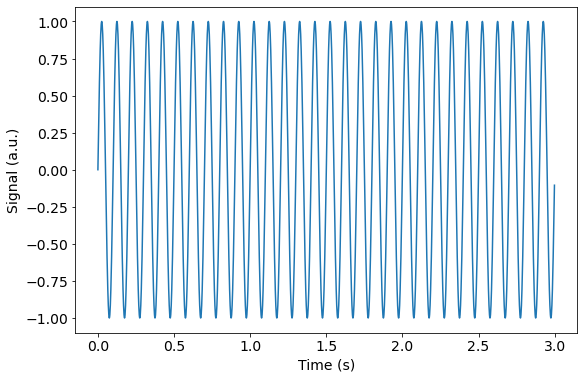

In [60]:
fig, ax = create_plots()
ax.plot( t,h )
ax.set_xlabel( 'Time (s)' )
ax.set_ylabel( 'Signal (a.u.)')

As we want to make use of Parsival's theorem, we need to calculate the integral over $h(t)^2$

In [31]:
from scipy.integrate import trapezoid

ih2 = trapezoid( h**2, dx=dt)
print(f'∫h(t)² dt = {ih2}')

∫h(t)² dt = 1.4999908948336391


Calculate the frequencies and the FFT for the signal and shift them so that the have the 'human readable' order. To distinguish the *analytically* calculated Fourier transform of $h(t)$ from the *numerically* calculated FFT, we denote the latter with $\hat h(f)$

In [32]:
ff = fftshift( fftfreq( len(h), dt ) )
hf = fftshift( fft(h) )

Plot the real and the imaginary part. As the sine is an odd function, the real part should be zero. 

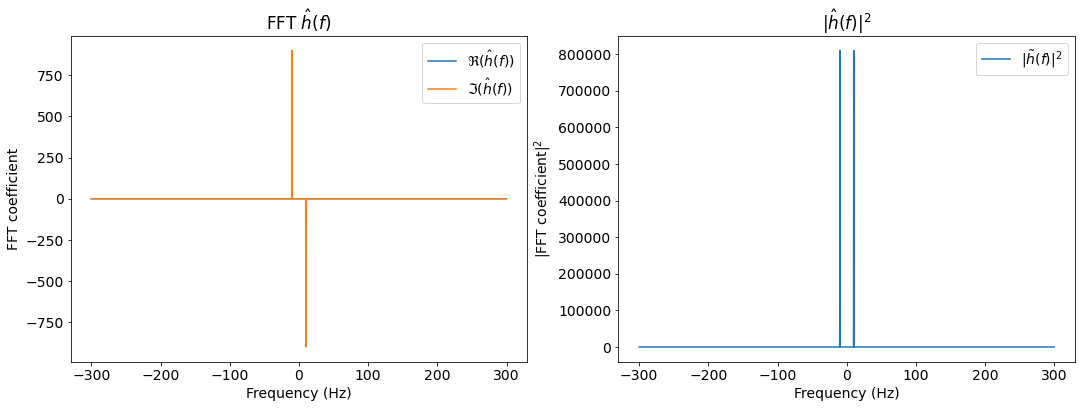

In [34]:
fig, ax = create_plots(ncols=2)

ax[0].plot( ff, np.real(hf), label=r'$\Re(\hat h(f))$')
ax[0].plot( ff, np.imag(hf),label=r'$\Im(\hat h(f))$' )

ax[0].set_xlabel('Frequency (Hz)')
ax[0].set_ylabel('FFT coefficient')
ax[0].set_title('FFT $\hat h(f)$')
             
ax[0].legend()

ax[1].plot(ff, np.abs(hf)**2, label=r'$|\tilde h(f)|^2$')
ax[1].set_xlabel('Frequency (Hz)')
ax[1].set_ylabel(r'|FFT coefficient|$^2$')
ax[1].set_title('$|\hat h(f)|^2$')
ax[1].set_yscale('linear')             
ax[1].legend()

In the following we report three numbers per step. The simple sum of the elements multiplied with the width of the frequency bin $\Delta f$ (denoted `df`), a numerical intergation using the trapezoidal rule and the value of $\int h^2(t)\, \mathrm{d}t$ (denoted `ih2`).

The first attempt with an unscaled FFT results in much too large numbers.

In [35]:
df = (ff[1]-ff[0])
( np.sum( np.abs(hf)**2 )*df, trapezoid( np.abs(hf)**2, dx=df), ih2 )

(540000.0000000612, 540000.0000000612, 1.4999908948336391)

Even if we only add the positive frequencies:

In [36]:
ix = np.where(ff>=0)
( np.sum( np.abs(hf[ix])**2 )*df, trapezoid( np.abs(hf[ix])**2, dx=df), ih2 )

(270000.0000000306, 270000.0000000306, 1.4999908948336391)

If we scale by the frequency range, though, we get the right result if we integrate over all positive frequencies and compensate for the missing negative frequencies with a factor 2

\begin{align}
\int\limits_0^T\! h(t)^2 \,\mathrm{d}t &= \frac{1}{f_\text{max}^2} \int\limits_{-f_\text{max}}^{f_\text{max}}\! |\hat h(f)|^2 \,\mathrm{d}f\\
&= \frac{2}{f_\text{max}^2} \int\limits_0^{f_\text{max}}\! |\hat h_+(f)|^2 \,\mathrm{d}f
\end{align}

Here, $T$ is the measurement time. Note that in the second equation we limit the integral to positive frequencies. To make that clear, we introduce the $\hat h_+(f)$ which has the same value as $\hat h(f)$ but is only evaluated at positive frequencies. This additional notation is not strictly necessary, but it serves as a reminder that we need to restrict the frequencies to be positive when we use the numerical formulas.

In [37]:
frange = (ff[-1]-ff[0])
(2*np.sum( (1/frange*np.abs(hf[ix]))**2 )*df, 2*trapezoid( (1/frange*np.abs(hf[ix]) ) **2, dx=df), ih2)

(1.5016680565852476, 1.5016680565852476, 1.4999908948336391)

As the frequency range is simply the with of the frequency bins $\Delta f$ (denoted `df`) multiplied by the number of bins `N`, we get

\begin{align}
\int\limits_0^T\! h(t)^2 \,\mathrm{d}t &=  2 \int\limits_0^{f_\text{max}}\! \frac{|\hat h_+(f)|^2}{(N \Delta f)^2} \,\mathrm{d}f
\end{align}

In [38]:
N=len(ff)
print(f'N = {N}')
print(f'df = {df}')
print(f'Frequency range = {frange} = {N*df} = N*df') 
print(f'''
Sum()*df\t= {2*np.sum( (1/(N*df)*np.abs(hf[ix]))**2 )*df}
trapezoid()\t= {2*trapezoid( ( 1/(N*df)*np.abs(hf[ix]) ) **2, dx=df)}
∫h(t)² dt\t= {ih2}''')

N = 1800
df = 0.33333333333337123
Frequency range = 599.6666666666666 = 600.0000000000682 = N*df

Sum()*df	= 1.4999999999998292
trapezoid()	= 1.4999999999998292
∫h(t)² dt	= 1.4999908948336391


So we found the scaling we needed - from comparing eq (PT) with the equation above, we get
\begin{align}
 |\tilde h(f)|^2 &= \frac{2}{(N\Delta f)^2}|\hat h_+(f)|^2 \tag{S1}
\end{align}
or as $\Delta f = 1/T$
\begin{align}
 |\tilde h(f)|^2 &= 2\frac{T^2}{N^2}|\hat h_+(f)|^2 \tag{S2}
\end{align}

## Scaling the PSD

For the PSD we look into a time series of gaussian noise. We just collect a large number of samples and then tell the `welch` method to use the right sampling frequency to get the scaling correct. We also produce a few more samples so that we can average.

In [43]:
from scipy.stats import norm
from scipy.signal import welch, periodogram

In [44]:
sigma=1
rv = norm.rvs(loc=0, scale=sigma, size=2**24)

In [45]:
xfn, psdn = welch( rv, fs =1/dt, nperseg=len(h), window='nuttall', scaling='density')

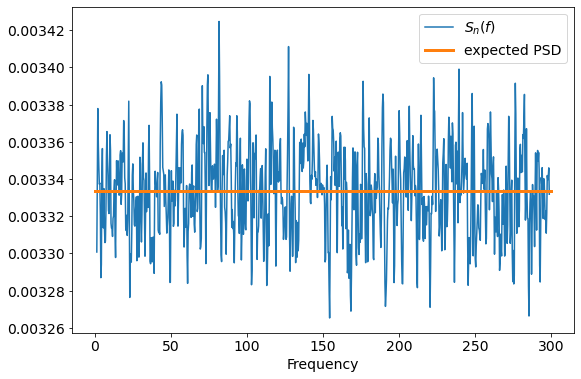

In [59]:
fig, ax = plt.subplots(figsize=(9,6) )

ax.plot( xfn[4:-4], psdn[4:-4], label='$S_n(f)$')
ax.plot( xfn, np.ones_like(xfn)*sigma**2/xfn[-1], label='expected PSD', linewidth=3)
ax.set_xlabel('Frequency')
ax.legend()

We expect the integral over the *single-sided* PSD to be the variance of the time series, ie

\begin{align}
\mathop{\text{var}}(n(t)) &= \int\limits_0^{\infty}\!\!S_n(f) \,\mathrm{d}f\tag{V}
\end{align}

so for a PSD constant over a frequency interval $(0, f_\text{max})$ and 0 outside that interval (as we have constructed here) we expect
\begin{align}
S_n(f) &= \frac{\mathop{\text{var}}(n(t))}{f_\text{max}}
\end{align}

and as we constructed the noise $n(t)$ such that

\begin{align}
\mathop{\text{var}}(n(t)) &= \sigma^2
\end{align}

we expect to see 
\begin{align}
S_n(f) &= \frac{\sigma^2}{f_\text{max}}
\end{align}

which is exactly what we do see in the plot above. So the PSD calculated with the `welch` method is correctly scaled for the **integral**:

In [48]:
( trapezoid(psdn, dx=df), sigma**2)

(0.9989126094648887, 1)

## Scaling the SNR

### Using the FFT of the signal and the PSD of the noise
So we can now put the two results together. We use eq (S2) to express $|\tilde h(f)|$ by $|\hat h(f)|$:

\begin{align}
\rho^2 &= 8 \frac{T^2}{N^2} \int\limits_0^{\infty}\!\frac{|\hat h_+(f)|^2}{S_n(f)}\,\mathrm{d}f
\end{align}

Numerically approximating the integral by a sum over the (non-negative) FFT frequencies $f_k$ and using $\Delta f = 1/T$ we get
\begin{align}
\hat\rho^2 &= 8 \frac{T}{N^2} \sum_{f_k\geq0}\!\frac{|\hat h_+(f_k)|^2}{S_n(f_k)}\tag{SNR 1}
\end{align}




We introduce the notation $\hat \rho^2$ to denote the numerically evaluated SNR in distinction to the analytical $\rho^2$. 

### Using the FFT of the signal and the FFT of the noise

Using eq (V) and the definition of the variance and Parsival's theorem to express $S_n(f)$ by $|\tilde n(f)|^2$

\begin{align}
\mathop{\text{var}}\bigl( n(t) \bigr) & = \int\limits_0^\infty\! S_n(f) \,\mathrm{d}f
\end{align}

The variance of the signal is also defined as 
\begin{align}
\mathop{\text{var}}\bigl( n(t) \bigr) & = \frac{1}{T} \int\limits_0^T \! n(t)^2 \,\mathrm{d}t\\
\end{align}

and we can extend the limits of the integral if we assume that $n(t)$ is zero outside the measurement interval:
\begin{align}
\mathop{\text{var}}\bigl( n(t) \bigr) & = \frac{1}{T} \int\limits_0^\infty \! n(t)^2 \,\mathrm{d}t\\
\end{align}

Parsival's theorem allows to then write 
\begin{align}
\mathop{\text{var}}\bigl( n(t) \bigr)  &= \frac{1}{T} \int\limits_0^\infty\! |\tilde n(f)|^2 \,\mathrm{d}f\\
&= \frac{T}{N^2} \int\limits_0^\infty\! |\hat n(f)|^2 \,\mathrm{d}f
\end{align}
using the eq (S2).

Comparing the integrands, we get
\begin{align}
S_n(f)&= \frac{T}{N^2}|\hat n_+(f)|^2
\end{align}

where we introducet $\hat n_+(f)$ in analogy to $\hat h_+(f)$ to remind us of the fact that only the positive frequencies will be used. It then follows

\begin{align}
\rho^2 &= 4 T\int\limits_0^{\infty}\!\frac{|\hat h(f)|^2}{|\hat n(f)|^2}\,\mathrm{d}f
\end{align}

As above, we approximate the integral by taking the sum over all non-negative FFT frequencies and multiply by $\Delta f$
\begin{align}
\hat \rho^2 &= 8 T\sum_{f_k\geq0}\!\frac{|\hat h_+(f_k)|^2}{|\hat n_+(f_k)|^2} \Delta f
\end{align}

and as $\Delta f = 1/T$ we get
\begin{align}
\hat\rho^2 &= 8 \sum_{f_k\geq0}\!\frac{|\hat h_+(f_k)|^2}{|\hat n_+(f_k)|^2} \tag{SNR 2}
\end{align}

If we drop the requirement to only add up over the positive frequencies, which requires an additional step to identify the elements in the arrays that correspond to positive frequencies, we get

\begin{align}
\hat\rho^2 &= 4 \sum_{f_k}\!\frac{|\hat h(f_k)|^2}{|\hat n(f_k)|^2} \tag{SNR 2a}
\end{align}

where the sum now extends over *all* frequencies.

### Using the PSD of the signal and the PSD of the noise
From eq (SNR 2), we can also get a third way to calculate $\hat \rho^2$. As long as numerator and denominator of the summed terms have *the same scaling*, we do not have to know (or care) about the that scaling. So instead of the |FFT|$^2$, we can also use the PSD of the signal and the noise, as they can be calculated with the `periodogram` or the `welch` function.

\begin{align}
\hat\rho^2 &= 8 \sum_{f_k\geq0}\!\frac{\hat S_h(f_k)}{\hat S_n(f_k)} \tag{SNR 3}
\end{align}

To distinguish the numerically evaluated PSD from the analytical PSD, we denote the former with a $\hat S$, in analogy to the other evaluted quantities.

###Testing

We can test the two expressions in eq (SNR 1) and eq (SNR 2) with the signal and the noise we defined above.

### Using the FFT for the signal and the PSD of the noise
Eq (SNR 1) can be evalauted directly, if we calculate the PSD with the `welch` function, as it allows to define the numbers of samples per segment and hence the $\Delta f$. So if we make sure that we use the same length as the signal, we get can divide the two arrays.
We already calculated the FFT of the signal $h(t)$ (`hf`) and we restrict it to non-negative frequencies.

In [49]:
xf, psd_n = welch( rv, fs =1/dt, nperseg=len(h)-1, window='boxcar', detrend=False)

The array `ff` contains the frequencies of the FFT, already shifted to be ordered by value. As we only want the positive-frequency elements of the FFT `hf` we define an index `ix`

In [50]:
ix = np.where( ff>=0)

In [51]:
T= t[-1]
N=len( psd_n)

In [52]:
snr_1 = np.sqrt( 4*T/N**2*np.sum( np.abs(hf[ix])**2/psd_n) )
print(f'SNR 1 = {snr_1}')

SNR 1 = 59.88097241618166


### Using the FFT for both the signal and the noise

As our noise is significantly longer than the signal, let's recast it into many shorter stretches

In [53]:
newlen = len(h)*( len(rv)//len(h) )
newrv = np.reshape( rv[ : newlen], (-1, len(h)))
newrv.shape

(9320, 1800)

We can now calculate the fft of each of the stretches, shifting the elements so that they are ordered by frequency - that way we are able to use the same `ix` as above. Note that both `fft` and `fftshift` are fully aware of array inputs.

In [54]:
nrvf = fftshift( fft( newrv )) 

We can now calulate the SNR for each of the short stretch and average the |FFT|$^2$ to reduce the noise in the noise a bit.

In [55]:
nrvf2_mean = np.mean( (np.abs(nrvf)**2), axis=0)

We use eq (SNR 2a) as this means we can just add over all the frequencies, without bothering about what frequenciy is positive. If we did not shift the elements of `hf` alrqeady earlier, shifting the `nrvf` would not be needed either.

In [56]:
snr_2 = np.sqrt(4*np.sum( np.abs(hf)**2/nrvf2_mean )) 

In [57]:
print(f'''SNR 1\t= {snr_1}
SNR 2a\t= {snr_2}''')

SNR 1	= 59.88097241618166
SNR 2a	= 59.85219776844266


### The direct calculation

As the PSD in our case is constant over the frequency interval, the calculation of the SNR can be done easily analytically as well

\begin{align}
\rho^2 &= 4 \frac{f_\text{max}}{\sigma^2}\int\! |\tilde h(f)|^2 \, \mathrm{d}f \\
&= 4 \frac{f_\text{max}}{\sigma^2}\int\! |h(t)|^2 \, \mathrm{d}t
\end{align}

where we made use of Parsival's theorem again and used the expression for the constant PSD $S_n = \sigma^2/f_\text{max}$. 

In [58]:
print(f'''SNR 1\t= {snr_1}
SNR 2a\t= {snr_2}
Direct\t= {np.sqrt(4*frange/sigma**2*ih2)}''')

SNR 1	= 59.88097241618166
SNR 2a	= 59.85219776844266
Direct	= 59.983148964863084


# Conclusions

All three equations
1. Using the FFT of the signal and the PSD of the noise (SNR 1)
2. Using the FFT of the signal and the FFT of the noise (SNR 2/2a)
3. Using the PSD of the signal and the PSD of the noise (SNR 3)

give the same result within the numerical accuracy and accounting for different window functions. What method should be used depends on the format of the signal and the noise.

If signal and noise have the same measurement time, (SNR 2a) is the simplest, most straight-forward way to calculate the SNR. If the noise is based on a different measurement length (eg from a very long noise run), method (SNR 1) or (SNR 3) is more useful, as the PSD can be estimated via the `welch` method which allows to give the effective length of the PSD.

If the PSD of the noise is known analytically and the signal is only known numerically, (SNR 1) is the method to use. If both, signal and noise are known analytically, the SNR should be calculated analytically as well. If this is not possible as the resulting integral might not have a solution in closed form, (SNR 3) should be used.